In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fitsio
from fitsio import FITS,FITSHDR
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import stats
from astropy.table import Table, Column
from astropy.io import ascii
from scipy.interpolate import griddata
from sklearn import neighbors
import matplotlib.lines as mlines
from scipy.stats import kde
import matplotlib.colors as clr

## Best fit polynomial to isochrone data

In [17]:
def polynomial(x,y):
    return (-44.27677739 + (x*(115.67737032)) + (y*(-24.5631504)) + ((x*y)*(93.56679366)) + ((x**2)*(-108.01788098)) + ((y**2)*(-118.19369438)) + ((x**2)*y*(-78.89488701)) + ((y**2)*x*(150.57376231)) + ((x**3)*(37.64771891)) + ((y**3)*(-65.50782695)))


## Upload parsec isochrone data

In [18]:

data = '/Users/amyel/research/SMASH_project/datafiles/parsec_decamsdss_3.0gyr.fits.gz'
fx = fitsio.FITS(data)
objs = fx[1].read()

In [19]:
u_des = objs['DECAM_U']
g_des = objs['DES_G']
r_des = objs['DES_R']
i_des = objs['DES_I']
z_des = objs['DES_Z']
feh_des = objs['FEH']
u_g_des = u_des - g_des
g_r_des = g_des - r_des


In [20]:
u_g_des = u_g_des + .3

In [21]:
#apply shift found in isochrone_minimize_residuals_01OCT2019
u_g_des = u_g_des - .005
g_r_des = g_r_des - .005

In [22]:
#reduce area to around selection box
selected = np.where((u_g_des>=0.4)&(u_g_des<=1.3)&(g_r_des>=0)&(g_r_des<=0.4))
u_g_des = u_g_des[selected]
g_r_des = g_r_des[selected]
feh_des = feh_des[selected]

In [23]:
print('number of stars in isochrone image calibration sample',len(feh_des))

number of stars in isochrone image calibration sample 9618


## Upload original calibration sample (with SDSS/LAMOST matches)

In [24]:
data = '/Users/amyel/research/SMASH_project/datafiles/new_SMASH_SDSS_LAMOST_crossmatch.fits'
fx = fitsio.FITS(data)
objs = fx[1].read()

In [25]:
#deredden calibration sample
u_cal = (objs["U"]-(4.239*objs["EBV"]))
g_cal = (objs["G"]-(3.303*objs["EBV"]))
i_cal = (objs["I"]-(1.263*objs["EBV"]))
r_cal = (objs["R"]-(2.285*objs["EBV"]))
feh_cal = objs["FEH"]
u_g_cal = u_cal - g_cal
g_r_cal = g_cal - r_cal

# Upload APOGEE/SMASH matches and add them to original calibration sample

In [26]:
#now, upload the corssmatches from apogee and smash
data = '/Users/amyel/research/SMASH_project/datafiles/apogee_smash_xmatch.fits'
fx = fitsio.FITS(data)
objs_apogee = fx[1].read()

In [27]:
selected = np.where((objs_apogee["LOGG"]>-10) & (objs_apogee["TEFF"] > 0) & (objs_apogee["FE_H"]>-10) & (objs_apogee["U"]>-10) &(objs_apogee["U"]<30) &(objs_apogee["G"]>-10) &(objs_apogee["G"]<30) &(objs_apogee["R"]>-10) &(objs_apogee["R"]<30))
objs_apogee = objs_apogee[selected]

/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [28]:
#deredden calibration sample
u_new =np.append(u_cal,(objs_apogee["U"]-(4.239*objs_apogee["EBV"])))
g_new =np.append(g_cal,(objs_apogee["G"]-(3.303*objs_apogee["EBV"]))) 
i_new =np.append(i_cal,(objs_apogee["I"]-(1.263*objs_apogee["EBV"]))) 
r_new =np.append(r_cal,(objs_apogee["R"]-(2.285*objs_apogee["EBV"]))) 
feh_new = np.append(feh_cal,objs_apogee["FE_H"])
u_g_new = u_new - g_new
g_r_new = g_new - r_new

In [29]:
ret = {}
xedge = {}
yedge = {}
bin = {}

In [31]:
for i,method in enumerate(('original','updated','iso_image')):
    ret[method] = []
    xedge[method] = []
    yedge[method] = []
    bin[method] = [] 

In [32]:
ret['original'],xedge['original'],yedge['original'],bin['original'] = stats.binned_statistic_2d((u_g_cal),(g_r_cal),feh_cal,'median',50)
ret['iso_image'],xedge['iso_image'],yedge['iso_image'],bin['iso_image'] = stats.binned_statistic_2d(u_g_des,g_r_des,feh_des,'median',50)    
ret['updated'],xedge['updated'],yedge['updated'],bin['updated'] = stats.binned_statistic_2d(u_g_new,g_r_new,feh_new,'median',70)    


/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


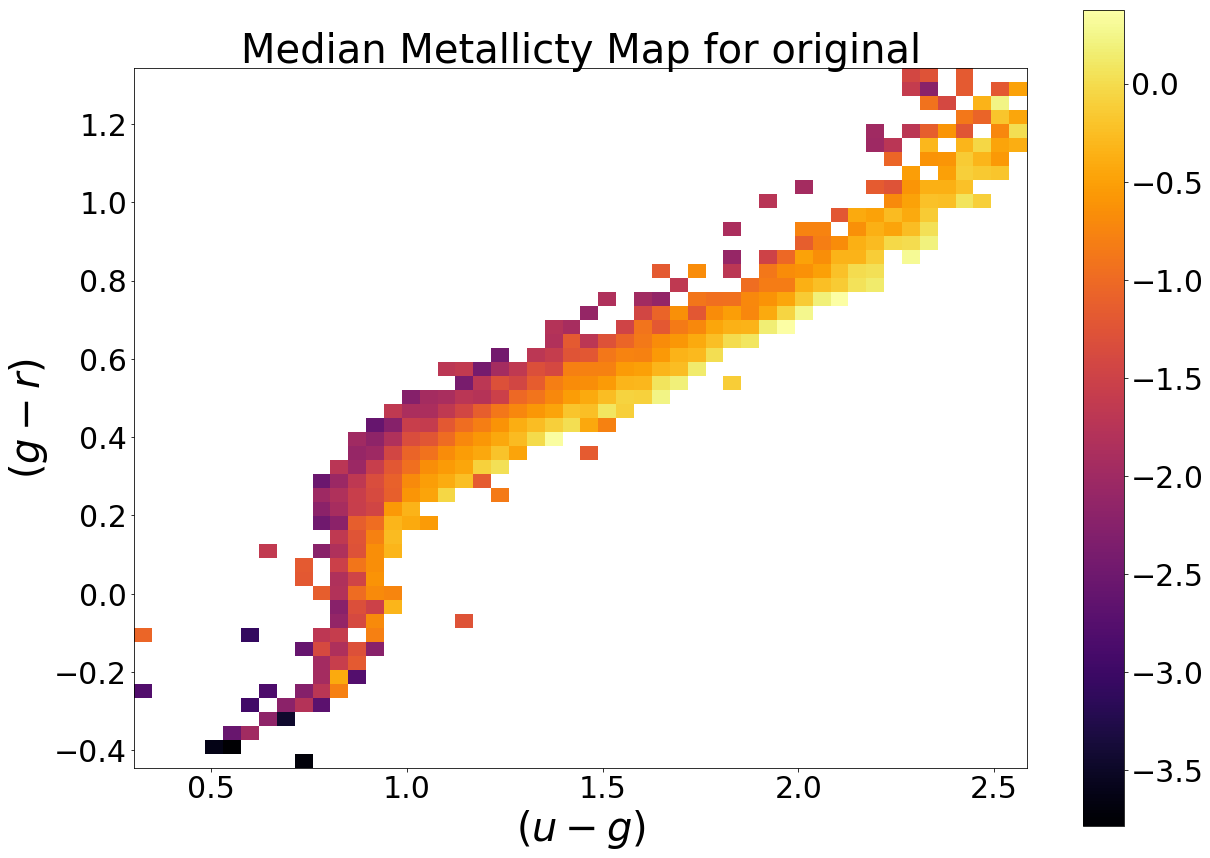

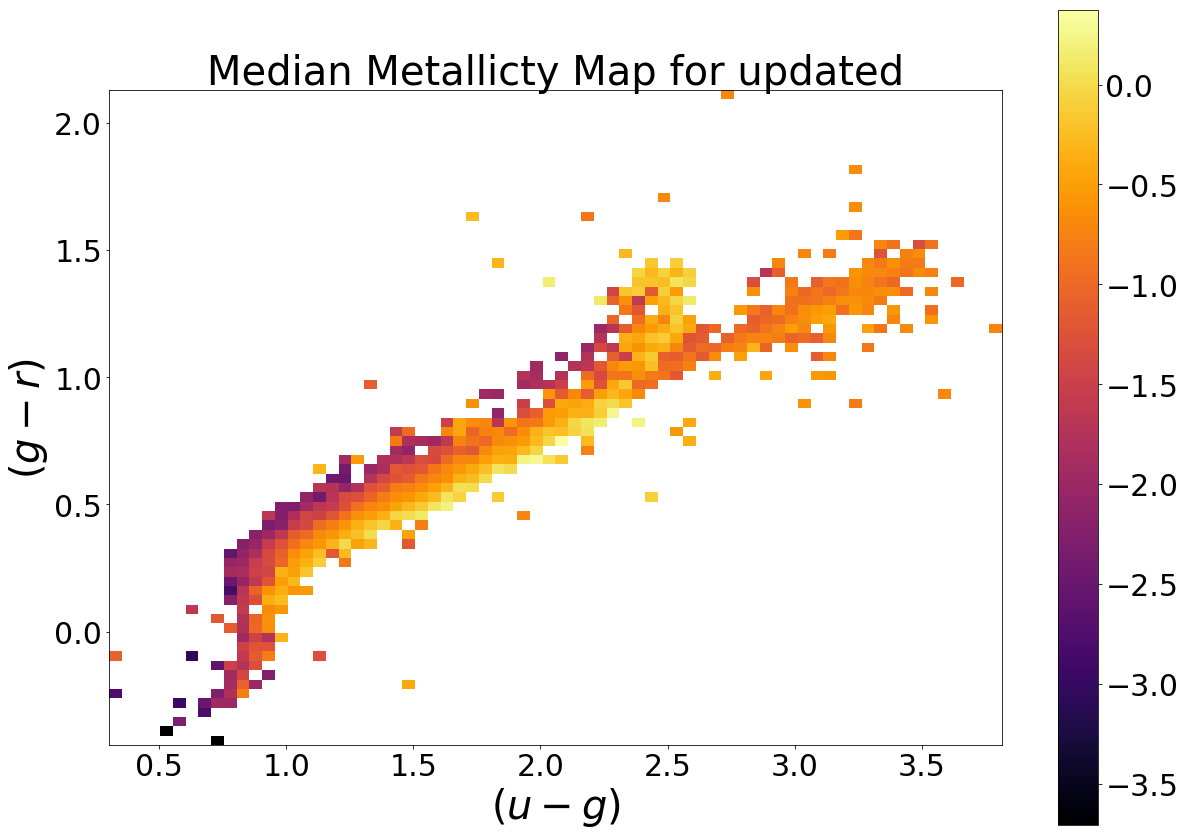

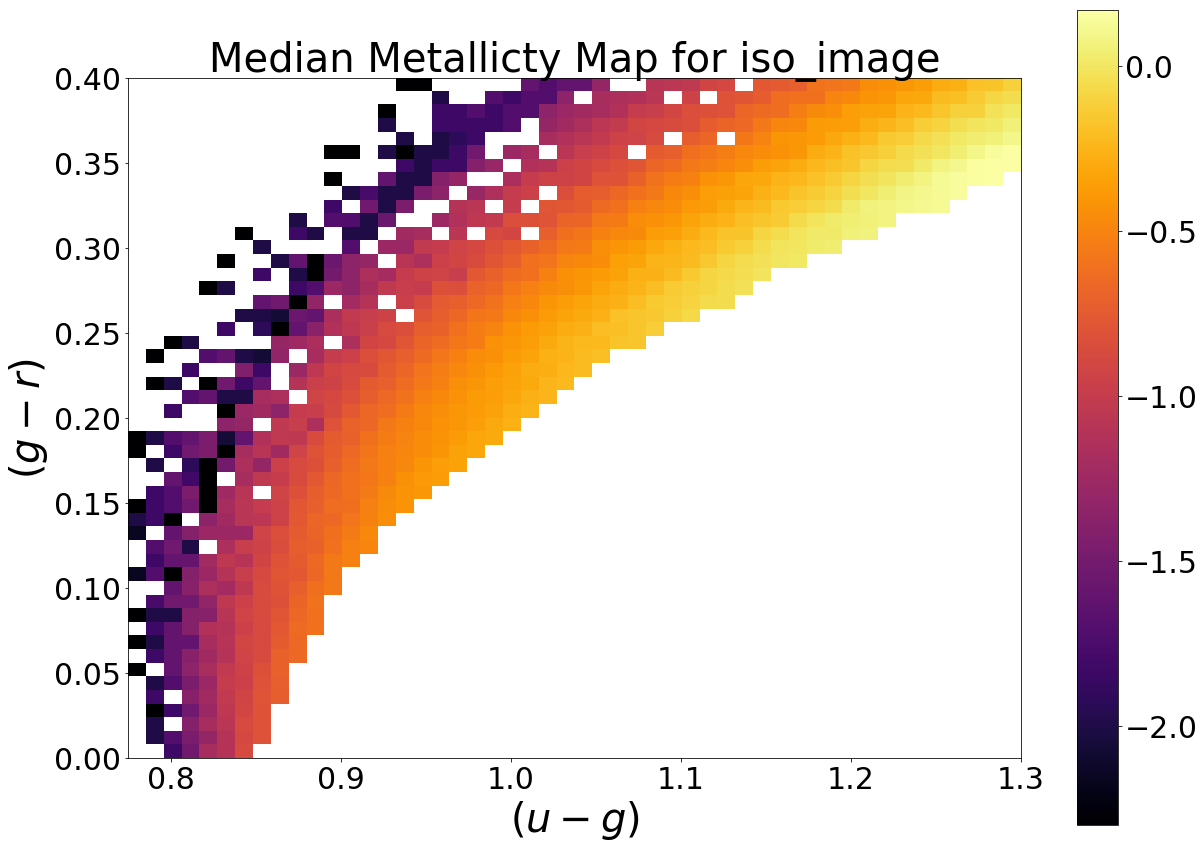

In [34]:
for i,method in enumerate(('original','updated','iso_image')):
    fig, ax = plt.subplots(figsize=(20,15))
    im = ax.imshow(ret[method].T,origin='lower',extent=[xedge[method].min(),xedge[method].max(),yedge[method].min(),yedge[method].max()],cmap='inferno')
    ax.set_title('Median Metallicty Map for '+method,fontsize=40)
    ax.set_xlabel('$(u-g)$',fontsize=40)
    ax.set_ylabel('$(g-r)$',fontsize=40)
    
    ax.tick_params(axis='both', which='major', labelsize=30)
    cb=fig.colorbar(im,ax=ax)
    ticklabs = cb.ax.get_yticklabels()
    cb.ax.set_yticklabels(ticklabs, fontsize=30)
    

In [79]:
fields= [1,   2,   3,   4,   5,   7,   8,   9,  12,  13,  14,  15,  16,
        18,  19,  20,  21,  22,  24,  26,  27,  28,  29,  31,  32,  33,
        34,  37,  40,  44,  46,  49,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  63,  64,  66,  68, 149, 150, 156, 176, 177,
       178]

In [80]:
metal = {}
std = {}
error = {}
initial_stars = []
cut_stars = []
for i, method in enumerate (('original','iso_image','iso_poly','updated','og_color','updated_color','image_color','poly_color')):
    metal[method] = []
    std[method] = []
    error[method] = []


In [81]:

#function to calculate metallicity in SMASH fields of interest
###calculates metallicity using information from binned_statistic_2d 
###reads out metallicity using yumi's method
###output is four different metallicity values: original calibration, nearest interpolation, linear interpolation, cubic interpolation
def metallicity(filename):
    
    #read fits file
    fx = fitsio.FITS(filename)
    objs_new = fx[1].read()
    
    #extract field number from filename string
    newstr = ''.join((ch if ch in '0123456789' else ' ') for ch in filename)
    field_number = [int(i) for i in newstr.split()]
    
    #initial number of stars in each field
    print("number of initial stars in field "+str(field_number[0])+": "+str(len(objs_new)))
    initial_stars.append(len(objs_new))
    
    #deredden the colors from input file
    u = (objs_new["U"]-(4.239*objs_new["EBV"]))
    g = (objs_new["G"]-(3.303*objs_new["EBV"]))
    i = (objs_new["I"]-(1.263*objs_new["EBV"]))
    r = (objs_new["R"]-(2.285*objs_new["EBV"]))

    #make cuts
    selected = np.where(((g-i)>=0.11)&((g-i)<=0.44)&(g>=21.9)&(g<=22.8)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))
    u = u[selected]
    g = g[selected]
    i = i[selected]
    r = r[selected]
    u_g = u-g
    g_r = g-r
    uerr = objs_new['UERR'][selected]
    gerr = objs_new['GERR'][selected]
    rerr = objs_new['RERR'][selected]
    
    
    #number of stars after cuts
    print("number of stars after cuts in field "+str(field_number[0])+": "+str(len(u)))
    cut_stars.append(len(u))
    stars = len(u)
    
    for i, method in enumerate(('original','updated','iso_image',)):
        ind, = np.where(((u_g)>=xedge[method].min())&((u_g)<=xedge[method].max())&((g_r)>=yedge[method].min())&((g_r)<=yedge[method].max()))
        ix = np.searchsorted(xedge[method],(u_g)[ind])
        ix = ix - 1
        iy = np.searchsorted(yedge[method],(g_r)[ind])
        iy = iy - 1
        feh = ret[method][ix,iy]
        metal[method].append(np.nanmean(feh))
        print("mean metallicity for "+method+" method:",(np.nanmean(feh)))
        std[method].append(np.nanstd(feh))
        N = np.count_nonzero(~np.isnan(feh))
        error[method].append((np.nanstd(feh))/np.sqrt(N))
    
    median_u_g = np.nanmedian(u_g)
    median_g_r = np.nanmedian(g_r)
    
    ix = np.searchsorted(xedge['original'],median_u_g)
    ix = ix-1 
    iy = np.searchsorted(yedge['original'],median_g_r)
    iy = iy-1
    feh = ret['original'][ix,iy]
    metal['og_color'].append(feh)

    ix = np.searchsorted(xedge['iso_image'],median_u_g)
    ix = ix-1 
    iy = np.searchsorted(yedge['iso_image'],median_g_r)
    iy = iy-1
    feh = ret['iso_image'][ix,iy]
    metal['image_color'].append(feh)
    
    ix = np.searchsorted(xedge['updated'],median_u_g)
    ix = ix-1 
    iy = np.searchsorted(yedge['updated'],median_g_r)
    iy = iy-1
    feh = ret['updated'][ix,iy]
    metal['updated_color'].append(feh)
    

    selected = np.where((u_g>=0.4)&(u_g<=1.3)&(g_r>=0)&(g_r<=0.4))
    u_g = u_g[selected]
    g_r = g_r[selected]
    
    feh = polynomial(u_g,g_r)
    #print("length of polynomial feh ",len(feh))
    metal['iso_poly'].append(np.nanmedian(feh))
    N = np.count_nonzero(~np.isnan(feh))
    print("number of stars in iso poly method: ",N)
    print("metallicity for iso poly method:",(np.nanmedian(feh)))
    #print(feh_method['poly'])
    std['iso_poly'].append(np.nanstd(feh))
    error['iso_poly'].append((np.nanstd(feh))/np.sqrt(N))
    metal['iso_poly'].append(np.nanmedian(feh))
    std['iso_poly'].append(np.nanstd(feh))
    error['iso_poly'].append((np.nanstd(feh))/np.sqrt(N))
    
    metal['poly_color'].append(polynomial(median_u_g,median_g_r))
    
    

    return 0


In [82]:

if __name__=="__main__":
    for number in fields:
        metallicity('/Users/amyel/research/SMASH_project/datafiles/SMASH_fields/vsix/starsthree/Field{}_allobj_deep_stars.fits.gz'.format(number))

              

number of initial stars in field 1: 46634
number of stars after cuts in field 1: 2849
mean metallicity for original method: -1.1979015631079901
mean metallicity for updated method: -1.2529141074857912
mean metallicity for iso_image method: -0.9812660680429356
number of stars in iso poly method:  916
metallicity for iso poly method: -4.2753296
number of initial stars in field 2: 61991
number of stars after cuts in field 2: 3435
mean metallicity for original method: -1.3346915244059585
mean metallicity for updated method: -1.366409538961293
mean metallicity for iso_image method: -1.0069886022084498
number of stars in iso poly method:  3299
metallicity for iso poly method: -2.02054
number of initial stars in field 3: 847797
number of stars after cuts in field 3: 65489
mean metallicity for original method: -1.351085761659954
mean metallicity for updated method: -1.3877100755486604
mean metallicity for iso_image method: -1.053663306754376
number of stars in iso poly method:  65167
metallici

number of initial stars in field 32: 1825281
number of stars after cuts in field 32: 152476
mean metallicity for original method: -1.2579174902984025
mean metallicity for updated method: -1.2719726345578533
mean metallicity for iso_image method: -0.9302851471060339
number of stars in iso poly method:  147977
metallicity for iso poly method: -1.2411492
number of initial stars in field 33: 45996
number of stars after cuts in field 33: 1105
mean metallicity for original method: -1.31790283979794
mean metallicity for updated method: -1.3677783453813317
mean metallicity for iso_image method: -0.9969150824333305
number of stars in iso poly method:  678
metallicity for iso poly method: -5.2714577
number of initial stars in field 34: 1421909
number of stars after cuts in field 34: 190149
mean metallicity for original method: -1.4102051637014255
mean metallicity for updated method: -1.43842221311022
mean metallicity for iso_image method: -1.036455302118711
number of stars in iso poly method:  1

number of initial stars in field 156: 122018
number of stars after cuts in field 156: 636
mean metallicity for original method: -1.2807988631710712
mean metallicity for updated method: -1.3624850893932634
mean metallicity for iso_image method: -0.958362827443669
number of stars in iso poly method:  505
metallicity for iso poly method: -4.4151354
number of initial stars in field 176: 111318
number of stars after cuts in field 176: 10154
mean metallicity for original method: -1.4175883049970412
mean metallicity for updated method: -1.4614458105342494
mean metallicity for iso_image method: -1.1029869337724076
number of stars in iso poly method:  10105
metallicity for iso poly method: -1.5157409
number of initial stars in field 177: 98553
number of stars after cuts in field 177: 2870
mean metallicity for original method: -1.3445800366517033
mean metallicity for updated method: -1.3737283720722766
mean metallicity for iso_image method: -1.0475955163560262
number of stars in iso poly method:

In [57]:
lmc = [32,34,37,40,46,49,51,156,24,26,27,28,29,31,33,44,52,53,54,55,56,57,58,59,60,61,63,64,66,68]
smc = [12,14,15,16,19,2,3,4,5,7,9,1,13,149,150,176,177,178,18,20,21,22,8]

In [58]:
old = [1, 2, 3, 4, 5, 7, 8, 9, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 40, 42, 44, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 66, 68, 149, 150, 156, 176, 177, 178, 246]


In [59]:
#ra and dec of each SMASH field and of the centers of LMC/SMC: WARNING: correspond to old fields array!!!!!!!!!!!!!
ra = np.array([2.58282, 4.74128, 5.8295, 6.23604, 11.0282, 11.2637, 12.6438, 15.3642, 17.2959, 19.3929, 20.1116, 21.1397, 22.3556, 32.3014, 33.2987, 33.7735, 38.0154, 40.8729, 48.7252, 55.0714, 62.0399, 62.2076, 71.5224, 72.8794, 73.2326, 73.826, 74.3797, 74.8251, 75.6417, 78.0543, 79.5644, 81.6974, 83.023, 84.5087, 85.416, 87.2541, 87.3605, 89.5211, 96.3535, 96.7494, 98.0372, 98.2317, 107.298, 108.637, 111.26, 111.286, 114.087, 114.673, 118.049, 120.112, 128.154, 130.919, 351.667, 351.815, 115.38663, 10.65102, 22.45883, 25.12044, 101.835])
dec = np.array([-69.7946, -77.0834, -73.9689, -72.3856, -71.6294, -74.8041, -82.474, -70.7182, -75.4505, -78.5112, -71.2591, -72.825, -74.3674, -73.2717, -77.5124, -67.4354, -70.2838, -74.5334, -72.4893, -76.4147, -72.0384, -68.4171, -75.3739, -68.7777, -80.7479, -70.5799, -84.3086, -72.3767, -67.5258, -66.2141, -72.8687, -66.6022, -76.3886, -73.2367, -66.8939, -71.7809, -68.5956, -70.2803, -79.9982, -67.1805, -75.1855, -70.3668, -68.3137, -54.6223, -59.3505, -64.5201, -76.1913, -70.9916, -67.0089, -84.4426, -72.6595, -76.0996, -72.0863, -67.6899, -54.888583, -67.7937, -67.39283, -71.2175, -52.264999])
#associated SkyCoord object
c_fields = SkyCoord(ra,dec,unit='deg')

#LMC center
ra_lmc = 81.900000
dec_lmc = -69.866667
#SMC center
ra_smc = 13.183333
dec_smc = -72.828333
#associated SkyCoord objects
c_lmc = SkyCoord(ra_lmc,dec_lmc,unit='deg')
c_smc = SkyCoord(ra_smc,dec_smc,unit='deg')

#calculate radii from LMC/SMC center
radii_lmc = c_fields.separation(c_lmc).degree
radii_smc = c_fields.separation(c_smc).degree

#calculate position angle to LMC/SMC center
pa_lmc = c_fields.position_angle(c_lmc).degree
pa_smc = c_fields.position_angle(c_smc).degree

In [60]:
lmc_index_old = []
for i in np.arange(0,len(old)):
    for j in lmc:
        if old[i]==j:
            lmc_index_old.append(i)

In [61]:

lmc_index = []
for i in np.arange(0,len(fields)):
    for j in lmc:
        if fields[i]==j:
            lmc_index.append(i)

In [62]:
smc_index = []
for i in np.arange(0,len(fields)):
    for j in smc:
        if fields[i]==j:
            smc_index.append(i)

In [63]:
smc_index_old = []
for i in np.arange(0,len(old)):
    for j in smc:
        if old[i]==j:
            smc_index_old.append(i)

In [85]:
metal['offset'] = [i+0.6 for i in metal['original']]

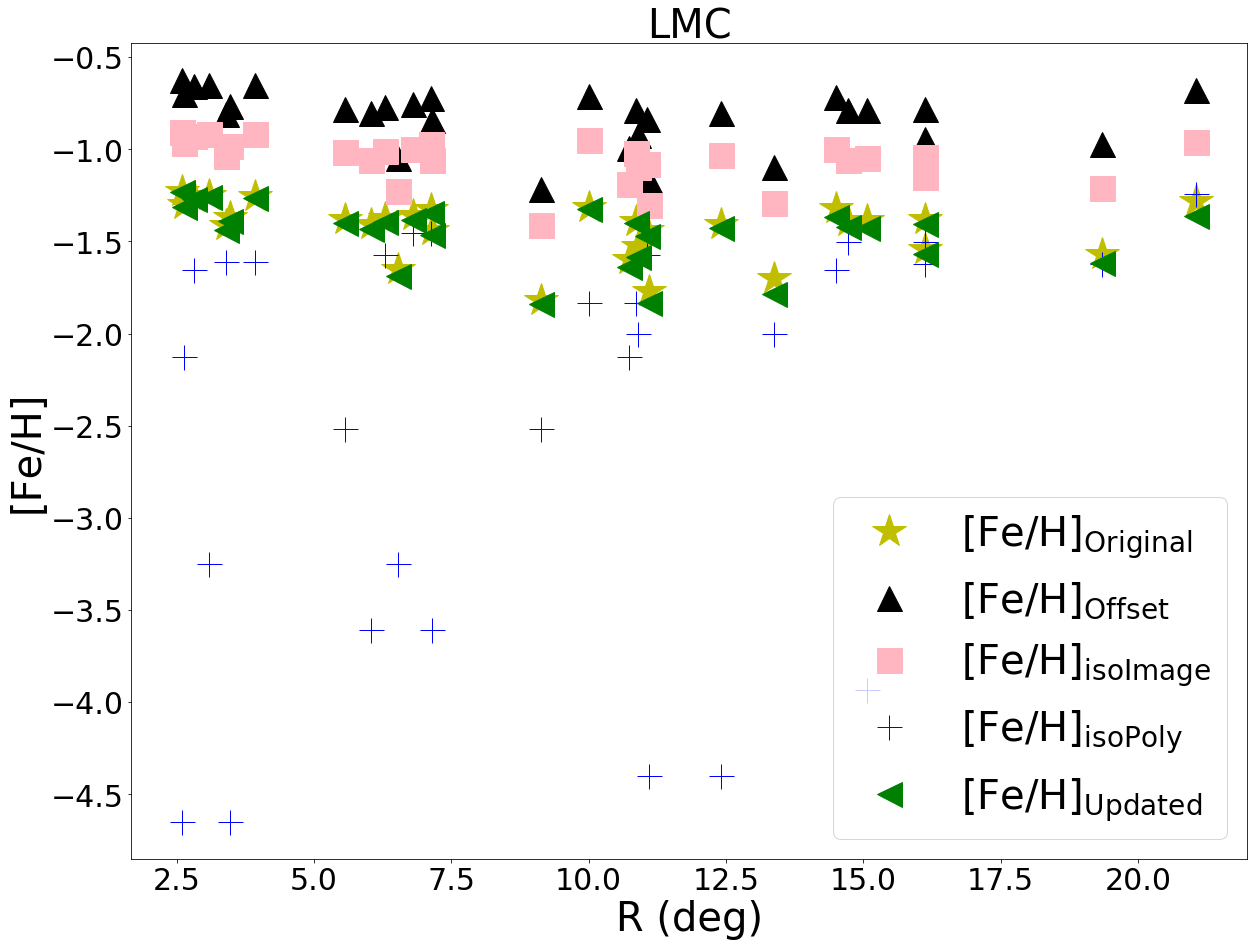

In [86]:
#plots of Fe/H versus radii for LMC
#index = np.argsort(radii_lmc)
fig, ax = plt.subplots(figsize=(20,15))
colors = ['y','k','lightpink','b','g','c','m','tab:orange','tab:brown','tab:gray','lime','lightsteelblue','maroon','deeppink','indigo','darkslategray','darkseagreen']

ax.errorbar(radii_lmc[lmc_index_old],np.array(metal['original'])[lmc_index],fmt='*',c=colors[0],markersize=35,label='[Fe/H]$_{\mathregular{Original}}$')
ax.errorbar(radii_lmc[lmc_index_old],np.array(metal['offset'])[lmc_index],fmt='^',c=colors[1],markersize=25,label='[Fe/H]$_{\mathregular{{Offset}}}$')
ax.errorbar(radii_lmc[lmc_index_old],np.array(metal['iso_image'])[lmc_index],fmt='s',c=colors[2],markersize=25,label='[Fe/H]$_{\mathregular{isoImage}}$')
ax.errorbar(radii_lmc[lmc_index_old],np.array(metal['iso_poly'])[lmc_index],fmt='+',c=colors[3],markersize=25,label='[Fe/H]$_{\mathregular{isoPoly}}$')
ax.errorbar(radii_lmc[lmc_index_old],np.array(metal['updated'])[lmc_index],fmt='<',c=colors[4],markersize=25,label='[Fe/H]$_{\mathregular{Updated}}$')



plt.title('LMC',fontsize=40)
plt.xlabel('R (deg)',fontsize=40)
plt.ylabel('[Fe/H]',fontsize=40)
        

ax.tick_params(axis='both', which='major', labelsize=30)
#ax.set_ylim(-2.2,-.6)
ax.legend(fontsize=40)
    

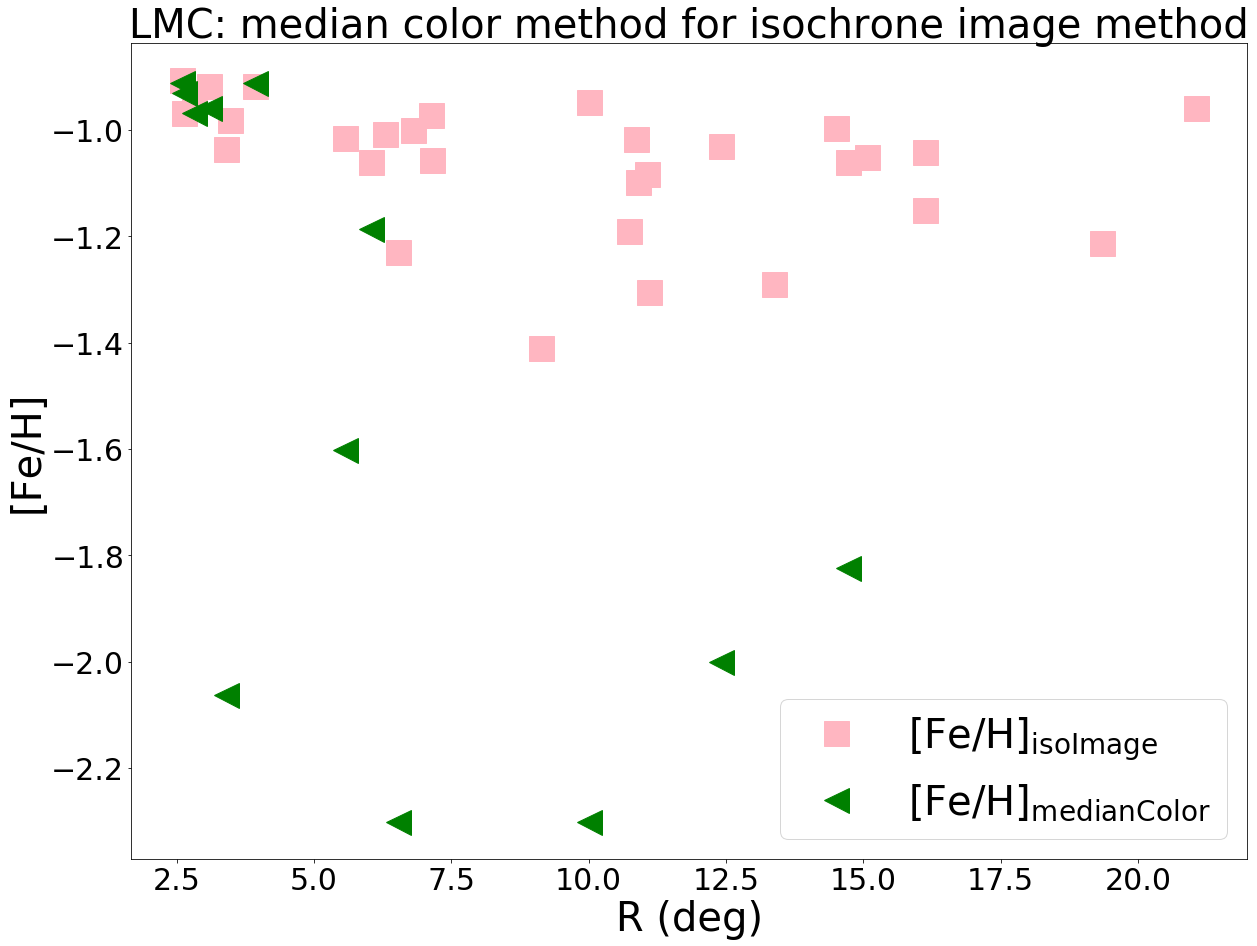

In [87]:
#plots of Fe/H versus radii for LMC
#index = np.argsort(radii_lmc)
fig, ax = plt.subplots(figsize=(20,15))
colors = ['y','k','lightpink','b','g','c','m','tab:orange','tab:brown','tab:gray','lime','lightsteelblue','maroon','deeppink','indigo','darkslategray','darkseagreen']

ax.errorbar(radii_lmc[lmc_index_old],np.array(metal['iso_image'])[lmc_index],fmt='s',c=colors[2],markersize=25,label='[Fe/H]$_{\mathregular{isoImage}}$')
ax.errorbar(radii_lmc[lmc_index_old],np.array(metal['image_color'])[lmc_index],fmt='<',c=colors[4],markersize=25,label='[Fe/H]$_{\mathregular{medianColor}}$')



plt.title('LMC: median color method for isochrone image method',fontsize=40)
plt.xlabel('R (deg)',fontsize=40)
plt.ylabel('[Fe/H]',fontsize=40)
        

ax.tick_params(axis='both', which='major', labelsize=30)
#ax.set_ylim(-2.2,-.6)
ax.legend(fontsize=40)

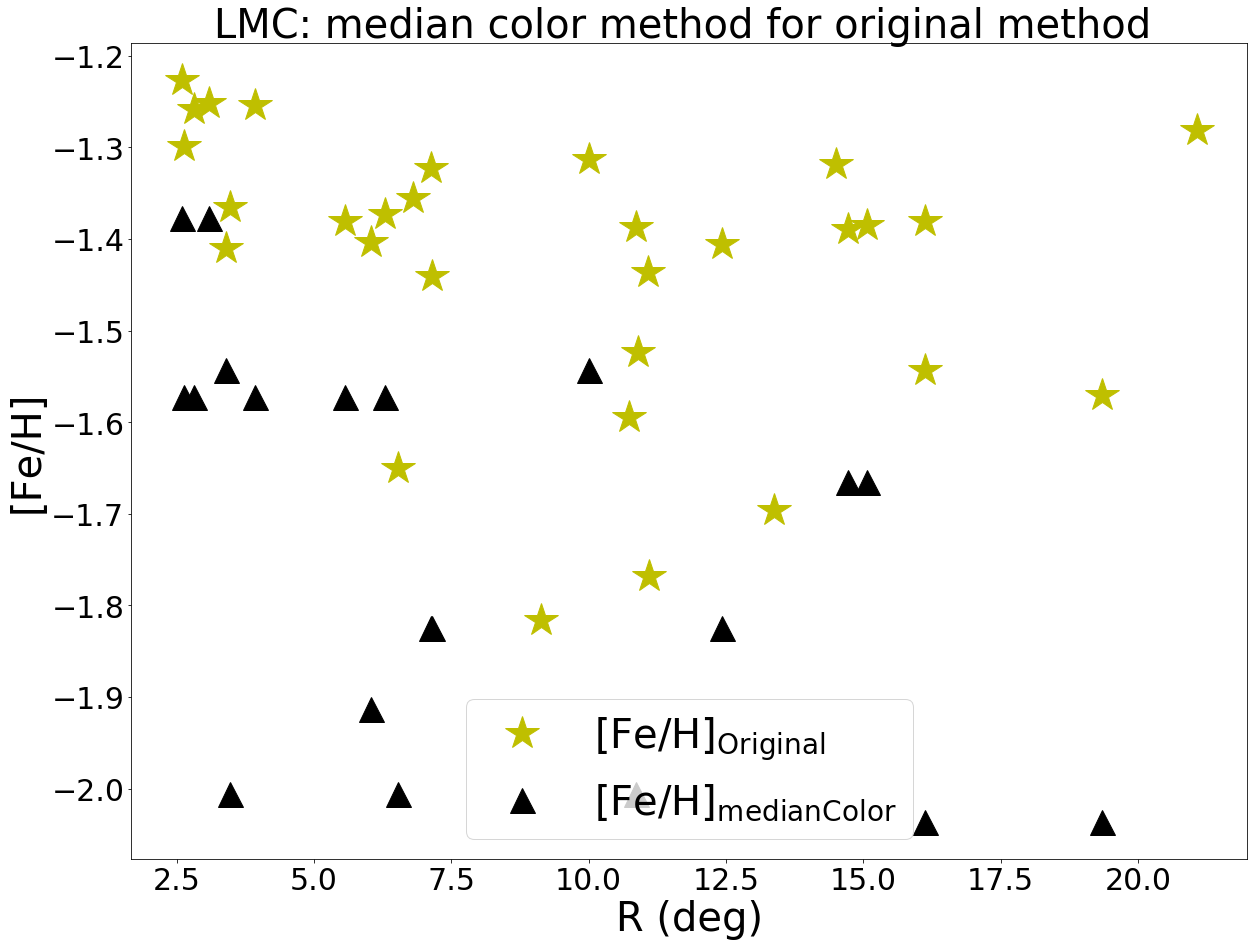

In [88]:
#plots of Fe/H versus radii for LMC
#index = np.argsort(radii_lmc)
fig, ax = plt.subplots(figsize=(20,15))
colors = ['y','k','lightpink','b','g','c','m','tab:orange','tab:brown','tab:gray','lime','lightsteelblue','maroon','deeppink','indigo','darkslategray','darkseagreen']

ax.errorbar(radii_lmc[lmc_index_old],np.array(metal['original'])[lmc_index],fmt='*',c=colors[0],markersize=35,label='[Fe/H]$_{\mathregular{Original}}$')
ax.errorbar(radii_lmc[lmc_index_old],np.array(metal['og_color'])[lmc_index],fmt='^',c=colors[1],markersize=25,label='[Fe/H]$_{\mathregular{{medianColor}}}$')



plt.title('LMC: median color method for original method ',fontsize=40)
plt.xlabel('R (deg)',fontsize=40)
plt.ylabel('[Fe/H]',fontsize=40)
        

ax.tick_params(axis='both', which='major', labelsize=30)
#ax.set_ylim(-2.2,-.6)
ax.legend(fontsize=40)

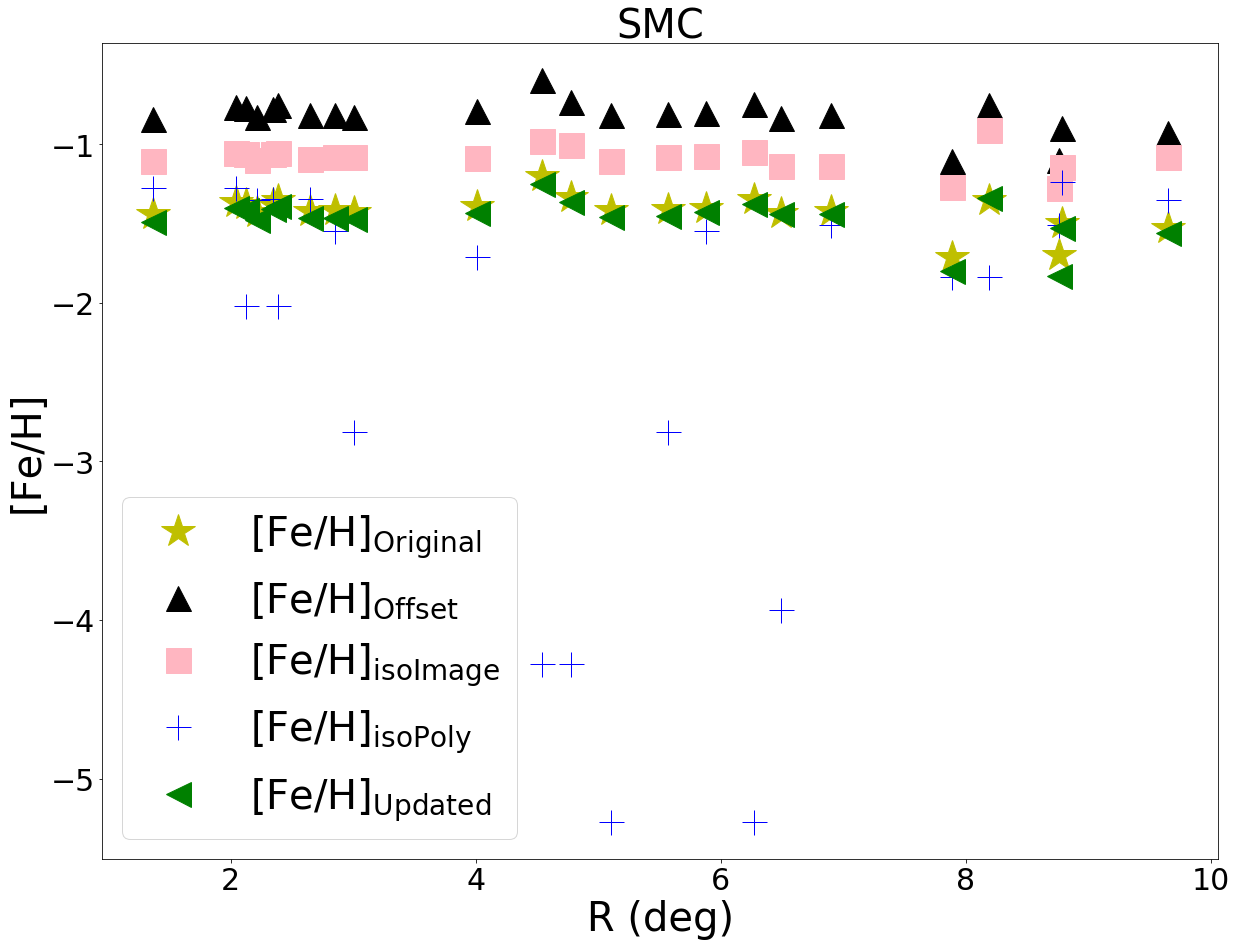

In [89]:
#plots of Fe/H versus radii for LMC
#index = np.argsort(radii_lmc)
fig, ax = plt.subplots(figsize=(20,15))
colors = ['y','k','lightpink','b','g','c','m','tab:orange','tab:brown','tab:gray','lime','lightsteelblue','maroon','deeppink','indigo','darkslategray','darkseagreen']

ax.errorbar(radii_smc[smc_index_old],np.array(metal['original'])[smc_index],fmt='*',c=colors[0],markersize=35,label='[Fe/H]$_{\mathregular{Original}}$')
ax.errorbar(radii_smc[smc_index_old],np.array(metal['offset'])[smc_index],fmt='^',c=colors[1],markersize=25,label='[Fe/H]$_{\mathregular{{Offset}}}$')
ax.errorbar(radii_smc[smc_index_old],np.array(metal['iso_image'])[smc_index],fmt='s',c=colors[2],markersize=25,label='[Fe/H]$_{\mathregular{isoImage}}$')
ax.errorbar(radii_smc[smc_index_old],np.array(metal['iso_poly'])[smc_index],fmt='+',c=colors[3],markersize=25,label='[Fe/H]$_{\mathregular{isoPoly}}$')
ax.errorbar(radii_smc[smc_index_old],np.array(metal['updated'])[smc_index],fmt='<',c=colors[4],markersize=25,label='[Fe/H]$_{\mathregular{Updated}}$')



plt.title('SMC',fontsize=40)

plt.xlabel('R (deg)',fontsize=40)
plt.ylabel('[Fe/H]',fontsize=40)
        

ax.tick_params(axis='both', which='major', labelsize=30)
#ax.set_ylim(-2.2,-.6)
ax.legend(fontsize=40)

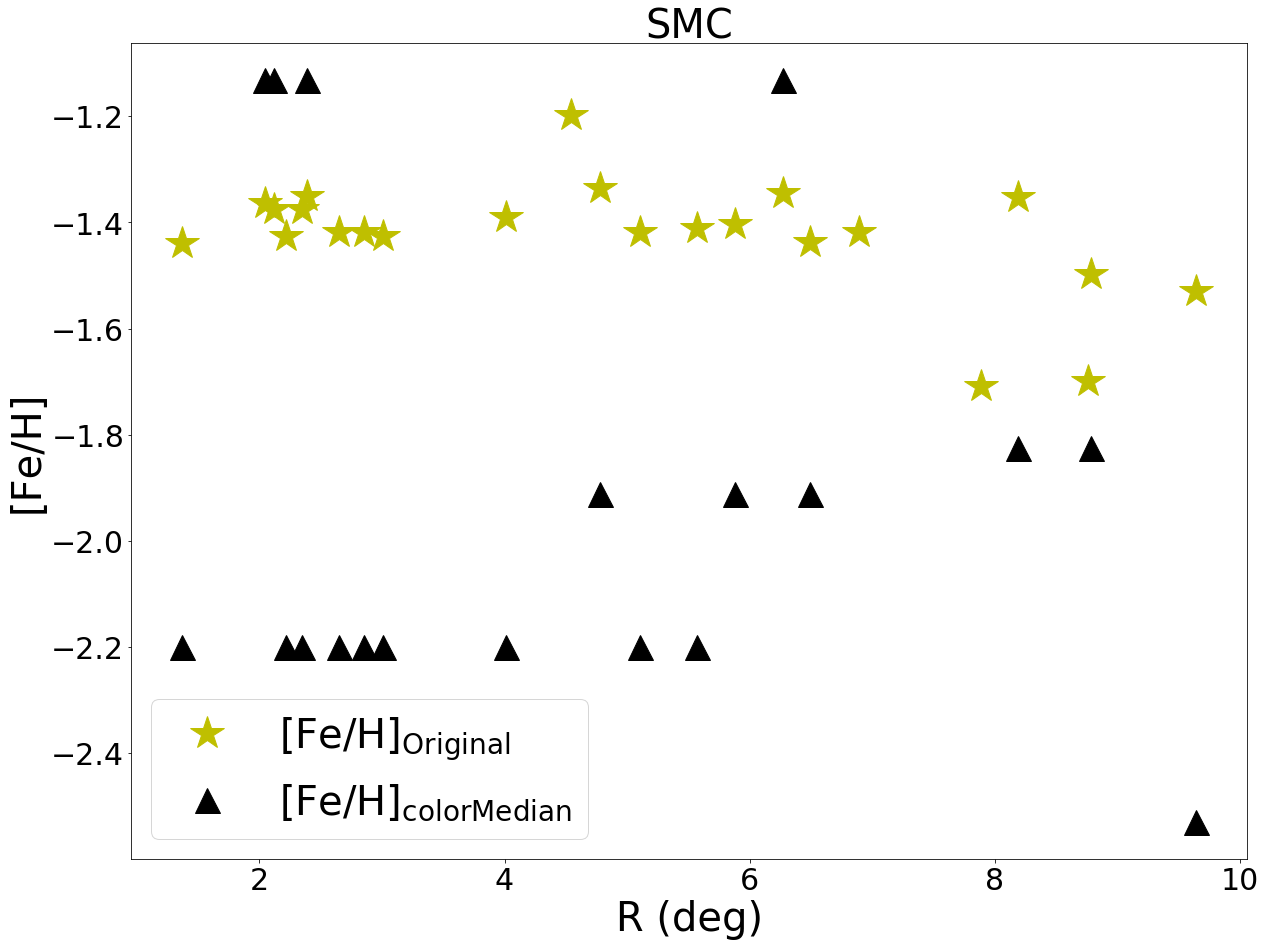

In [90]:
#plots of Fe/H versus radii for LMC
#index = np.argsort(radii_lmc)
fig, ax = plt.subplots(figsize=(20,15))
colors = ['y','k','lightpink','b','g','c','m','tab:orange','tab:brown','tab:gray','lime','lightsteelblue','maroon','deeppink','indigo','darkslategray','darkseagreen']

ax.errorbar(radii_smc[smc_index_old],np.array(metal['original'])[smc_index],fmt='*',c=colors[0],markersize=35,label='[Fe/H]$_{\mathregular{Original}}$')
ax.errorbar(radii_smc[smc_index_old],np.array(metal['og_color'])[smc_index],fmt='^',c=colors[1],markersize=25,label='[Fe/H]$_{\mathregular{{colorMedian}}}$')



plt.title('SMC: median color method for original method',fontsize=40)

plt.xlabel('R (deg)',fontsize=40)
plt.ylabel('[Fe/H]',fontsize=40)
        

ax.tick_params(axis='both', which='major', labelsize=30)
#ax.set_ylim(-2.2,-.6)
ax.legend(fontsize=40)

In [91]:
metal['poly_color']

[-25.690797591644735,
 -1.9052926741900063,
 -1.1911178309183004,
 -1.2602972483568433,
 -1.4587749083646733,
 -1.254821015652367,
 -2.8569229143440404,
 -1.4135618192773292,
 -1.7268687464848582,
 -1.6924153985293788,
 -1.35938099707302,
 -1.479135747377594,
 -1.5378818157316534,
 -1.5153621521456526,
 -3.4530642339111197,
 -4.794208466245747,
 -2.1414964034612782,
 -3.5660837083039203,
 -2.704233686718319,
 -1.602181818915277,
 -6.126261150500102,
 -1.9160780635668364,
 -1.4295573396607906,
 -4.387572145942907,
 -1.1397986733289578,
 -8.502284271646353,
 -1.6372110397850599,
 -1.1624062715702315,
 -1.0683014079592787,
 -2.384717050050523,
 -2.9103872113733478,
 -0.9569359413593705,
 -1.1267140744275395,
 -6.907525950714585,
 -1.5163139565202237,
 -1.8736790648322494,
 -1.5194488338194243,
 -3.6865820983074657,
 -2.6414598791156623,
 -2.5658261325986755,
 -1.9171232089062404,
 -11.780250728822306,
 -5.151041566516189,
 -3.25636276111011,
 -3.582304620626111,
 -2.0247403314771093,
 -1.

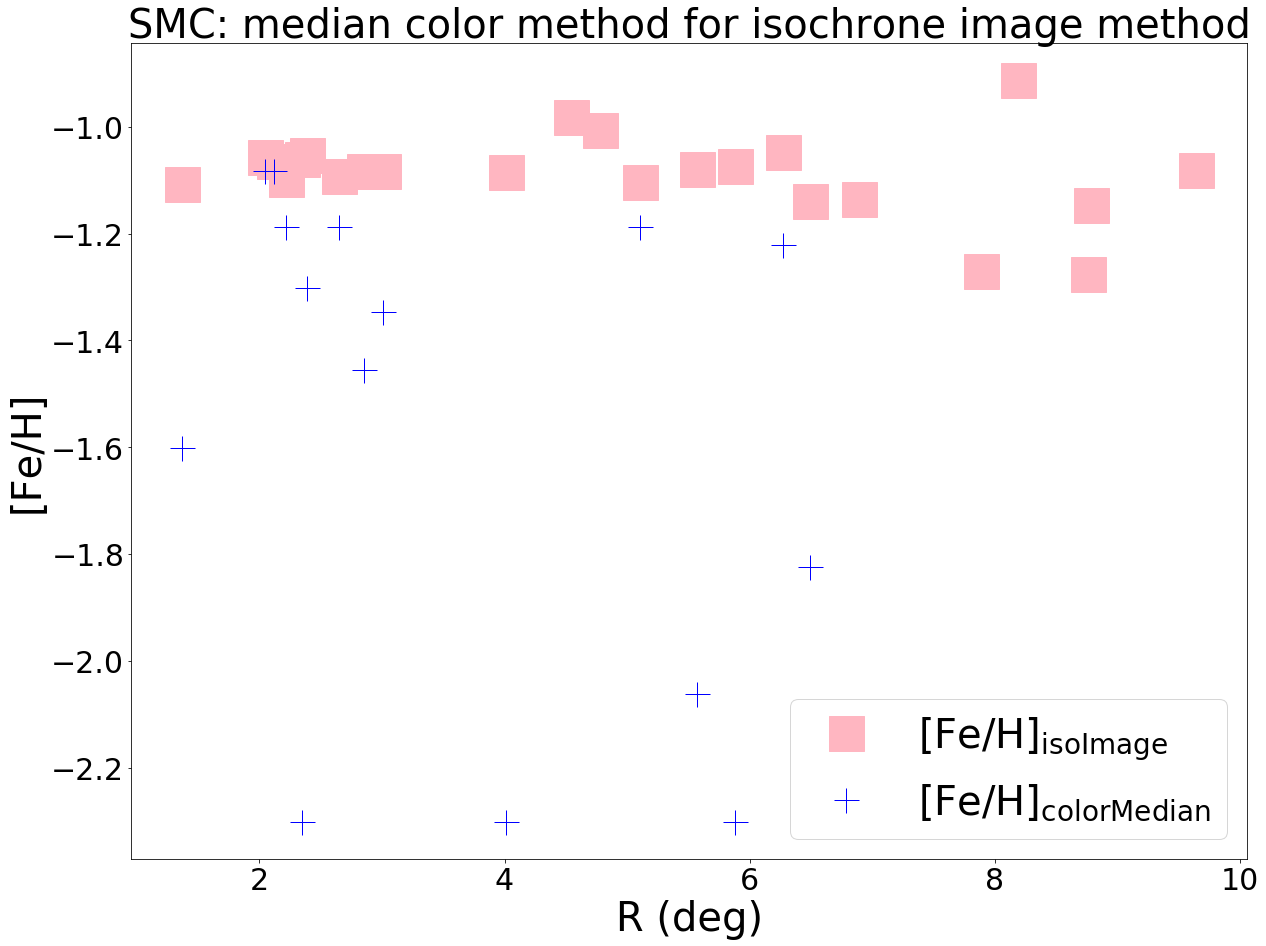

In [97]:

#plots of Fe/H versus radii for LMC
#index = np.argsort(radii_lmc)
fig, ax = plt.subplots(figsize=(20,15))
colors = ['y','k','lightpink','b','g','c','m','tab:orange','tab:brown','tab:gray','lime','lightsteelblue','maroon','deeppink','indigo','darkslategray','darkseagreen']

ax.errorbar(radii_smc[smc_index_old],np.array(metal['iso_image'])[smc_index],fmt='s',c=colors[2],markersize=35,label='[Fe/H]$_{\mathregular{isoImage}}$')
ax.errorbar(radii_smc[smc_index_old],np.array(metal['image_color'])[smc_index],fmt='+',c=colors[3],markersize=25,label='[Fe/H]$_{\mathregular{{colorMedian}}}$')

plt.title('SMC: median color method for isochrone image method',fontsize=40)

plt.xlabel('R (deg)',fontsize=40)
plt.ylabel('[Fe/H]',fontsize=40)
        
ax.tick_params(axis='both', which='major', labelsize=30)
#ax.set_ylim(-2.2,-.6)
ax.legend(fontsize=40)